In [215]:
import pandas as pd
import folium
import ast
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Load the data

In [162]:
# load the demographic profiles dataset from 
# https://data.cityofnewyork.us/City-Government/Demographic-Profiles-of-ACS-5-Year-Estimates-at-th/8cwr-7pqn/about_data
df_pop = pd.read_excel('./data/ACS5yrNTA/demo_2016acs5yr_nta.xlsx')
print(df_pop.shape)

df_econ = pd.read_excel('./data/ACS5yrNTA/econ_2016acs5yr_nta.xlsx')
print(df_econ.shape)

df_house = pd.read_excel('./data/ACS5yrNTA/hous_2016acs5yr_nta.xlsx')
print(df_house.shape)

df_soc = pd.read_excel('./data/ACS5yrNTA/soc_2016acs5yr_nta.xlsx')
print(df_soc.shape)

(195, 484)
(195, 659)
(195, 524)


/Users/TinyJiew/opt/anaconda3/envs/pantalone/lib/python3.10/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: #N/A.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


(195, 2714)


In [163]:
# load the demographic profiles dataset from 
# https://data.cityofnewyork.us/Business/Legally-Operating-Businesses/w7w3-xahh/about_data
df_bus = pd.read_csv('./data/Legally_Operating_Businesses_20240905.csv')
print(df_bus.shape)

/var/folders/mg/sts1jc3x4vg3ykt3408_lxs00000gn/T/ipykernel_11003/940827208.py:3: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bus = pd.read_csv('./data/Legally_Operating_Businesses_20240905.csv')


(281413, 27)


In [164]:
# check if there is any trader joe
df_bus[df_bus['Business Name'].str.lower().str.contains('trader') & df_bus['Business Name'].str.lower().str.contains('joe')]

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location


In [165]:
# filter business operating in NYC only
print(df_bus['Address Borough'].value_counts())

# filter the dataset to only keep 5 boroughs, remove rows with misspelling
NYC_BOROUGHS = ['Queens', 'Brooklyn', 'Manhattan', 'Bronx', 'Staten Island']
df_bus = df_bus[df_bus['Address Borough'].isin(NYC_BOROUGHS)]
print(df_bus.shape)

Address Borough
Brooklyn         50346
Queens           45800
Manhattan        40435
Bronx            24695
Outside NYC      14775
Staten Island     9265
MANHATTAN           46
QUEENS              17
BROOKLYN            15
BRONX                9
Name: count, dtype: int64
(170541, 27)


In [166]:
# We want to focus on recommending the specific NTA (Neighborhood Tabulation Area) where the business is located.
# remove row with missing NTA
df_bus = df_bus.dropna(subset=['NTA'])
print(df_bus.shape)

df_bus[['Address Borough', 'NTA']].value_counts()

(137476, 27)


Address Borough  NTA 
Manhattan        MN17    4222
                 MN13    2288
                 MN24    1936
Queens           QN70    1905
                 QN61    1904
                         ... 
Brooklyn         MN24       1
Manhattan        BK78       1
                 BK91       1
Brooklyn         MN19       1
Queens           MN36       1
Name: count, Length: 209, dtype: int64

In [167]:
# check how many industries
df_bus['Industry'].value_counts()[0:10]

Industry
Tobacco Retail Dealer             37491
Home Improvement Contractor       21261
Secondhand Dealer - General       12621
Electronics Store                 11933
Stoop Line Stand                   7376
Laundry                            6832
Electronic & Appliance Service     5325
Laundries                          4353
Laundry Jobber                     4339
Sidewalk Cafe                      3728
Name: count, dtype: int64

# Feature Engineering

In [168]:
# Assume that the trader joe's lies in between  Stoop Line Stand  and General Vendor industries
# [Note that general vendor was filtered as they are outside the NYC]
# let's use the sum of businesses of two industries as an indicator of supermarket success

df_sup_success = df_bus[df_bus['Industry'].isin(['Stoop Line Stand', 'General Vendor'])]
df_sup_success = df_sup_success[['Address Borough', 'NTA', 'Business Name', 'Industry']]
df_sup_success = df_sup_success.groupby(['Address Borough', 'NTA', 'Industry'])['Business Name'].count().reset_index()
df_sup_success = df_sup_success.rename(columns={'Business Name':'Shop_Count', 'NTA':'GeoID'})
df_sup_success.head(5)

,Address Borough,GeoID,Industry,Shop_Count
0,Bronx,BX01,Stoop Line Stand,13
1,Bronx,BX03,Stoop Line Stand,6
2,Bronx,BX05,Stoop Line Stand,54
3,Bronx,BX06,Stoop Line Stand,30
4,Bronx,BX07,Stoop Line Stand,10


In [169]:
# TODO get count of other industry

In [181]:
# create NTA-level data
df_nta = pd.merge(df_pop, df_sup_success, on='GeoID')
df_nta = pd.merge(df_nta, df_econ, on='GeoID')
df_nta = df_nta.drop(columns=['GeoType_x', 'GeoType_y', 'GeogName_x', 'GeogName_y', 'Borough_x', 'Borough_y'])
df_nta = pd.merge(df_nta, df_house, on='GeoID')
df_nta = pd.merge(df_nta, df_soc, on='GeoID')
df_nta = df_nta.drop(columns=['GeoType_x', 'GeoType_y', 'GeogName_x', 'GeogName_y', 'Borough_x', 'Borough_y'])
df_nta.shape

(181, 4369)

In [182]:
df_nta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Columns: 4369 entries, GeoID to UnclsNRZ
dtypes: float64(3511), int64(855), object(3)
memory usage: 6.0+ MB


In [184]:
# create new features
df_nta['Pop_Total_25_44'] = df_nta.apply(lambda x: x['Pop25t29E'] + x['Pop30t34E'] + x['Pop35t39E'] + x['Pop40t44E'], axis=1)
df_nta['Pop_Pct_25_44'] = df_nta.apply(lambda x: x['Pop_Total_25_44'] / x['Pop_1E'] , axis=1)
df_nta['Pop_Male'] = df_nta.apply(lambda x: x['MaleE'] / x['Pop_1E'] , axis=1)
df_nta['Pop_Female'] = df_nta.apply(lambda x: x['FemE'] / x['Pop_1E'] , axis=1)
df_nta['Median_Age'] = df_nta['MdAgeE']
df_nta['Pop_Pct_Hisp_Latin'] = df_nta.apply(lambda x: x['Hsp1E'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_Non_Hisp_Latin'] = df_nta.apply(lambda x: x['NHspE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_White'] = df_nta.apply(lambda x: x['WtNHE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_Black'] = df_nta.apply(lambda x: x['BlNHE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_American'] = df_nta.apply(lambda x: x['AIANNHE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_Asia'] = df_nta.apply(lambda x: x['AsnNHE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_Native'] = df_nta.apply(lambda x: x['NHPINHE'] / x['Pop_2E'], axis=1)
df_nta['Pop_Pct_Employ'] = df_nta.apply(lambda x: x['CvEm16pl1E'] / x['Pop16plE'], axis=1) 
df_nta['Pop_Pct_Employ_Salary'] = df_nta.apply(lambda x: x['PrvWSWrkrE'] / x['CvEm16pl4E'], axis=1) 
df_nta['Pop_Pct_Household_Earn_75_99'] = df_nta.apply(lambda x: x['HHI75t99E'] / x['HH2E'], axis=1) #earning $75,000 to $99,999
df_nta['Pop_Pct_Family_Earn_75_99'] = df_nta.apply(lambda x: x['FamI75t99E'] / x['Fam2E'], axis=1) #earning $75,000 to $99,999
df_nta['Median_Household_Income'] = df_nta['MnHHIncE']
df_nta['Median_Family_Income'] = df_nta['MdFamIncE']
df_nta['Median_Earning'] = df_nta['MdEWrkE']
df_nta['Pop_Pct_Healthy'] = df_nta.apply(lambda x: x['EmHInsE'] / x['CvLFEmE'], axis=1) #healthy with insurance coverage of overall employment
df_nta['Pop_Pct_With_Car'] = df_nta.apply(lambda x: (x['Vhcl1AvE'] + x['Vhcl2AvE'] + x['Vhcl3plAvE']) / x['OcHU4E'], axis=1)
df_nta['Pct_Occupied_House'] = df_nta.apply(lambda x: x['OcHU1E'] / x['HU1E'], axis=1)
df_nta['Median_Room'] = df_nta['MdRmsE']
df_nta['Median_House'] = df_nta['MdVlE'] #house price
df_nta['Median_Rent'] = df_nta['MdGRE']
df_nta['Pop_Pct_with_Family'] = df_nta.apply(lambda x: x['Fam1E'] / x['HH1E'], axis=1) 
df_nta['Pop_Pct_with_Couple'] = df_nta.apply(lambda x: x['MrdFamE'] / x['HH1E'], axis=1) 
df_nta['Pop_Pct_With_Degree'] = df_nta.apply(lambda x: x['EA_BchDHE'] / x['EA_P25plE'], axis=1)
df_nta['People_Per_Shop'] = df_nta.apply(lambda x: (x['Pop_Total_25_44'] / x['Shop_Count']) if x['Shop_Count'] > 0 else x['Pop_Total_25_44'], axis=1)

filtered_columns = ['Pop_Total_25_44', 'Pop_Pct_25_44', 'Pop_Male', 'Pop_Female', 'Median_Age',
                    'Pop_Pct_Hisp_Latin', 'Pop_Pct_Non_Hisp_Latin', 'Pop_Pct_White', 'Pop_Pct_Black',
                    'Pop_Pct_American', 'Pop_Pct_Asia', 'Pop_Pct_Native',
                    'Pop_Pct_Employ', 'Pop_Pct_Employ_Salary', 'Pop_Pct_Household_Earn_75_99', 'Pop_Pct_Family_Earn_75_99', 
                    'Median_Household_Income', 'Median_Family_Income', 'Median_Earning',
                    'Pop_Pct_Healthy', 'Pct_Occupied_House', 'Median_Room', 'Median_House', 'Median_Rent', 'Pop_Pct_With_Car', 
                   'Pop_Pct_with_Family', 'Pop_Pct_with_Couple', 'Pop_Pct_With_Degree', 'Shop_Count', 'People_Per_Shop', 'GeoID']

df_nta = df_nta[filtered_columns]

In [ ]:
# https://machinelearningmastery.com/feature-selection-for-regression-data/
# Feature selection instead, takes the target into consideration. 
# It will rank your input variables in terms of how useful they are to predict the target value.
# it is different from PCA that try to reduce dimensionality by exploring how one feature of the data is expressed 
# in terms of the other features(linear dependency)

def select_features(X_train, y_train, k):
 fs = SelectKBest(score_func=f_regression, k=k)
    
 # learn relationships from training data
 fs.fit(X_train, y_train)
    
 # transform train input data
 X_train_fs = fs.transform(X_train)
    
 return X_train_fs, fs

In [185]:
# remove columns that contain all missing rows
df_nta = df_nta.drop(columns=df_nta.columns[df_nta.isnull().all()].to_list())

# replace missing value with mean
for col in df_nta.columns:
    if col not in ['GeoID', 'Address Borough', 'Industry']:
        col_mean = df_nta[col].mean()
        df_nta[col].fillna(col_mean, inplace=True)

print(df_nta.columns[df_nta.isnull().any()])

Index([], dtype='object')


/var/folders/mg/sts1jc3x4vg3ykt3408_lxs00000gn/T/ipykernel_11003/687371754.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_nta[col].fillna(col_mean, inplace=True)


Feature Pop_Total_25_44: 0.680357
Feature Pop_Pct_25_44: 0.020308
Feature Pop_Male: 13.245171
Feature Pop_Female: 13.245171
Feature Median_Age: 0.546334
Feature Pop_Pct_Hisp_Latin: 4.292713
Feature Pop_Pct_Non_Hisp_Latin: 4.292713
Feature Pop_Pct_White: 0.006634
Feature Pop_Pct_Black: 5.956621
Feature Pop_Pct_American: 0.727472
Feature Pop_Pct_Asia: 1.835220
Feature Pop_Pct_Native: 3.046042
Feature Pop_Pct_Employ: 1.470845
Feature Pop_Pct_Employ_Salary: 1.651062
Feature Pop_Pct_Household_Earn_75_99: 3.669597
Feature Pop_Pct_Family_Earn_75_99: 2.468661
Feature Median_Household_Income: 1.135392
Feature Median_Family_Income: 3.266175
Feature Median_Earning: 2.069922
Feature Pop_Pct_Healthy: 4.730862
Feature Pct_Occupied_House: 0.105112
Feature Median_Room: 0.920259
Feature Median_House: 0.352363
Feature Median_Rent: 0.712296
Feature Pop_Pct_With_Car: 1.122637
Feature Pop_Pct_with_Family: 0.002201
Feature Pop_Pct_with_Couple: 0.125397
Feature Pop_Pct_With_Degree: 0.992911
Feature Shop_Coun

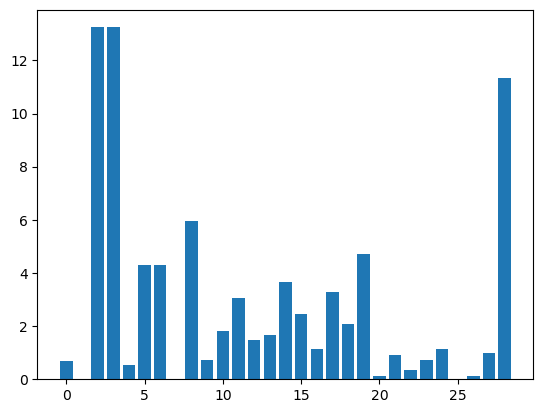

In [189]:
# feature selection
X_train_fs, fs = select_features(df_nta.drop(columns=['People_Per_Shop', 'GeoID']), df_nta['People_Per_Shop'], 15)
cols = df_nta.drop(columns=['People_Per_Shop', 'GeoID']).columns
# # what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %s: %f' % (cols[i], fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [190]:
selected_features = []
for idx, col in enumerate(cols):
    if fs.get_support()[idx]:
        selected_features.append(col)
selected_features

['Pop_Male',
 'Pop_Female',
 'Pop_Pct_Hisp_Latin',
 'Pop_Pct_Non_Hisp_Latin',
 'Pop_Pct_Black',
 'Pop_Pct_Asia',
 'Pop_Pct_Native',
 'Pop_Pct_Employ',
 'Pop_Pct_Employ_Salary',
 'Pop_Pct_Household_Earn_75_99',
 'Pop_Pct_Family_Earn_75_99',
 'Median_Family_Income',
 'Median_Earning',
 'Pop_Pct_Healthy',
 'Shop_Count']

# Clustering

K: 2 Score: 0.7415717251354238
K: 3 Score: 0.5654791776823921
K: 4 Score: 0.5404528860829497
K: 5 Score: 0.5067782386249247
K: 6 Score: 0.5034762268743788
K: 7 Score: 0.4719424360631316
K: 8 Score: 0.45853436541517895
K: 9 Score: 0.43560152782434153


Text(0.5, 1.0, 'Elbow Method For Optimal k')

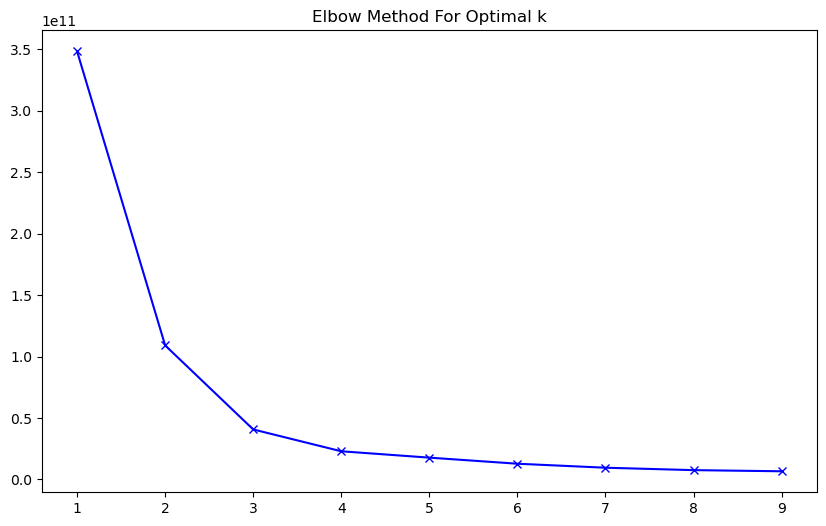

In [191]:
# Apply clustering on feature selection
sum_of_squared_distances = []

for k in range(1,10): # maximum of 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=20).fit(X_train_fs)
    sum_of_squared_distances.append(kmeans.inertia_)
    if k > 1:
        print(f"K: {k} Score: {silhouette_score(X_train_fs, kmeans.fit_predict(X_train_fs))}")

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')

In [192]:
# k = 3 is optimal number
k_clusters = 4

kmeans = KMeans(n_clusters=k_clusters, random_state=100).fit(X_train_fs)

In [220]:
nyc_cluster = df_nta.copy()
nyc_cluster['cluster'] = kmeans.labels_
nyc_cluster

,Pop_Total_25_44,Pop_Pct_25_44,Pop_Male,Pop_Female,Median_Age,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_White,Pop_Pct_Black,Pop_Pct_American,...,Median_House,Median_Rent,Pop_Pct_With_Car,Pop_Pct_with_Family,Pop_Pct_with_Couple,Pop_Pct_With_Degree,Shop_Count,People_Per_Shop,GeoID,cluster
0,10522,0.317281,0.503151,0.496849,38.3,0.176733,0.823267,0.436933,0.012182,0.000332,...,685011.0,1299.0,0.609205,0.718148,0.530189,0.336202,34,309.470588,BK27,3
1,24615,0.311055,0.478037,0.521963,39.5,0.178608,0.821392,0.634329,0.019094,0.002287,...,687001.0,1385.0,0.548691,0.565443,0.429271,0.464265,152,161.940789,BK31,0
2,25584,0.339680,0.484492,0.515508,29.1,0.194933,0.805067,0.350607,0.405826,0.000876,...,722811.0,1165.0,0.312752,0.557965,0.273034,0.321807,25,1023.360000,BK75,1
3,18681,0.290678,0.486766,0.513234,39.6,0.123283,0.876717,0.465153,0.008262,0.000000,...,657026.0,1209.0,0.540046,0.733583,0.531257,0.301847,105,177.914286,BK29,3
4,28128,0.306920,0.487212,0.512788,37.8,0.145975,0.854025,0.426773,0.008740,0.001211,...,708946.0,1259.0,0.526765,0.729948,0.537698,0.262382,173,162.589595,BK28,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,11003,0.294237,0.480439,0.519561,31.4,0.707046,0.292954,0.018986,0.231154,0.000882,...,213234.0,1098.0,0.228866,0.650325,0.232837,0.139636,32,343.843750,BX63,1
177,10220,0.285858,0.478435,0.521565,33.0,0.646090,0.353910,0.033061,0.251091,0.000587,...,453009.0,1108.0,0.394016,0.683944,0.280236,0.092649,40,255.500000,BX08,1
178,7933,0.278968,0.467068,0.532932,34.0,0.636249,0.363751,0.039420,0.151352,0.000000,...,425647.0,1308.0,0.522319,0.696242,0.339579,0.185358,30,264.433333,BX59,1
179,17193,0.264333,0.461541,0.538459,34.7,0.252156,0.747844,0.023461,0.692157,0.003413,...,378872.0,1204.0,0.512452,0.680864,0.278872,0.187137,42,409.357143,BX44,1


# Analyse clustering result

In [221]:
# merge the NTA metadata
nyc_cluster = pd.merge(nyc_cluster, df_pop[['GeogName', 'GeoID', 'Borough']], on = 'GeoID')
nyc_cluster.head(5)

,Pop_Total_25_44,Pop_Pct_25_44,Pop_Male,Pop_Female,Median_Age,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_White,Pop_Pct_Black,Pop_Pct_American,...,Pop_Pct_With_Car,Pop_Pct_with_Family,Pop_Pct_with_Couple,Pop_Pct_With_Degree,Shop_Count,People_Per_Shop,GeoID,cluster,GeogName,Borough
0,10522,0.317281,0.503151,0.496849,38.3,0.176733,0.823267,0.436933,0.012182,0.000332,...,0.609205,0.718148,0.530189,0.336202,34,309.470588,BK27,3,Bath Beach,Brooklyn
1,24615,0.311055,0.478037,0.521963,39.5,0.178608,0.821392,0.634329,0.019094,0.002287,...,0.548691,0.565443,0.429271,0.464265,152,161.940789,BK31,0,Bay Ridge,Brooklyn
2,25584,0.339680,0.484492,0.515508,29.1,0.194933,0.805067,0.350607,0.405826,0.000876,...,0.312752,0.557965,0.273034,0.321807,25,1023.360000,BK75,1,Bedford,Brooklyn
3,18681,0.290678,0.486766,0.513234,39.6,0.123283,0.876717,0.465153,0.008262,0.000000,...,0.540046,0.733583,0.531257,0.301847,105,177.914286,BK29,3,Bensonhurst East,Brooklyn
4,28128,0.306920,0.487212,0.512788,37.8,0.145975,0.854025,0.426773,0.008740,0.001211,...,0.526765,0.729948,0.537698,0.262382,173,162.589595,BK28,3,Bensonhurst West,Brooklyn


In [229]:
# create new dataframe to summarise each label
filtered_columns.pop()

results = []
for cluster in sorted(nyc_cluster.cluster.unique()):
    df = nyc_cluster[nyc_cluster.cluster == cluster]
    nta_names = df.GeogName.unique()
    nta_ids = df.GeoID.unique()
    cluster_dict = {
        'cluster': cluster,
        'NTA_Name': df.GeogName.unique(),
        'NTA_ID': df.GeoID.unique(),
    }
    for col in filtered_columns:
        cluster_dict[f'Avg_{col}'] = df[col].mean()
    results.append(cluster_dict)
    print(f"Group {cluster}")

Group 0
Group 1
Group 2
Group 3


In [230]:
df_results = pd.DataFrame(results)
df_results.head()

,cluster,NTA_Name,NTA_ID,Avg_Pop_Total_25_44,Avg_Pop_Pct_25_44,Avg_Pop_Male,Avg_Pop_Female,Avg_Median_Age,Avg_Pop_Pct_Hisp_Latin,Avg_Pop_Pct_Non_Hisp_Latin,...,Avg_Pct_Occupied_House,Avg_Median_Room,Avg_Median_House,Avg_Median_Rent,Avg_Pop_Pct_With_Car,Avg_Pop_Pct_with_Family,Avg_Pop_Pct_with_Couple,Avg_Pop_Pct_With_Degree,Avg_Shop_Count,Avg_People_Per_Shop
0,0,"[Bay Ridge, Carroll Gardens-Columbia Street-Re...","[BK31, BK33, BK69, BK38, BK45, BK76, BK64, BK4...",10344.052632,0.299691,0.479537,0.520463,40.178947,0.164363,0.835637,...,0.919888,4.736842,5.654421e+05,1501.289474,0.695833,0.624835,0.464345,0.444624,19.736842,1133.057865
1,1,"[Bedford, Borough Park, Brownsville, Bushwick ...","[BK75, BK88, BK81, BK77, BK78, BK61, BK63, BK8...",15828.258065,0.303833,0.477067,0.522933,32.822581,0.489305,0.510695,...,0.926199,3.891935,4.486493e+05,1087.129032,0.334790,0.647360,0.289840,0.200407,49.564516,753.094553
2,2,"[Brooklyn Heights-Cobble Hill, Park Slope-Gowa...","[BK09, BK37, MN25, MN21, MN13, MN31, MN14, MN1...",24744.500000,0.410936,0.467981,0.532019,37.918750,0.098467,0.901533,...,0.842817,3.225000,1.009718e+06,2230.312500,0.255912,0.377716,0.315751,0.788235,59.562500,2622.792934
3,3,"[Bath Beach, Bensonhurst East, Bensonhurst Wes...","[BK27, BK29, BK28, BK19, BK50, BK30, BK91, BK9...",13772.076923,0.300741,0.476110,0.523890,37.278462,0.226609,0.773391,...,0.924568,4.349231,5.009567e+05,1308.123077,0.589526,0.673519,0.424594,0.311564,40.000000,1280.642060


In [231]:
# for each attribute give me the label that has the highest average
best_cluster_per_feature = {}
for col in df_results.columns[3:]:
    if col != 'Avg_shop_count':
        max_index = df_results[col].idxmax()
        cluster = df_results.loc[max_index]['cluster']
    else:
        min_index = df_results[col].idxmin()
        cluster = df_results.loc[min_index]['cluster']
    print(f"Variable: {col} Cluster: {cluster}")
    best_cluster_per_feature[col] = cluster

Variable: Avg_Pop_Total_25_44 Cluster: 2
Variable: Avg_Pop_Pct_25_44 Cluster: 2
Variable: Avg_Pop_Male Cluster: 0
Variable: Avg_Pop_Female Cluster: 2
Variable: Avg_Median_Age Cluster: 0
Variable: Avg_Pop_Pct_Hisp_Latin Cluster: 1
Variable: Avg_Pop_Pct_Non_Hisp_Latin Cluster: 2
Variable: Avg_Pop_Pct_White Cluster: 2
Variable: Avg_Pop_Pct_Black Cluster: 1
Variable: Avg_Pop_Pct_American Cluster: 3
Variable: Avg_Pop_Pct_Asia Cluster: 3
Variable: Avg_Pop_Pct_Native Cluster: 3
Variable: Avg_Pop_Pct_Employ Cluster: 2
Variable: Avg_Pop_Pct_Employ_Salary Cluster: 2
Variable: Avg_Pop_Pct_Household_Earn_75_99 Cluster: 0
Variable: Avg_Pop_Pct_Family_Earn_75_99 Cluster: 3
Variable: Avg_Median_Household_Income Cluster: 2
Variable: Avg_Median_Family_Income Cluster: 2
Variable: Avg_Median_Earning Cluster: 2
Variable: Avg_Pop_Pct_Healthy Cluster: 2
Variable: Avg_Pct_Occupied_House Cluster: 1
Variable: Avg_Median_Room Cluster: 0
Variable: Avg_Median_House Cluster: 2
Variable: Avg_Median_Rent Cluster: 2


In [233]:
best_cluster = Counter(best_cluster_per_feature.values())
best_cluster = max(best_cluster, key=best_cluster.get)
best_cluster

2

In [235]:
nyc_cluster_result = nyc_cluster[nyc_cluster.cluster == best_cluster]
nyc_cluster_result = nyc_cluster_result.reset_index()
nyc_cluster_result.head(5)

,index,Pop_Total_25_44,Pop_Pct_25_44,Pop_Male,Pop_Female,Median_Age,Pop_Pct_Hisp_Latin,Pop_Pct_Non_Hisp_Latin,Pop_Pct_White,Pop_Pct_Black,...,Pop_Pct_With_Car,Pop_Pct_with_Family,Pop_Pct_with_Couple,Pop_Pct_With_Degree,Shop_Count,People_Per_Shop,GeoID,cluster,GeogName,Borough
0,7,10075,0.417357,0.497183,0.502817,37.2,0.080737,0.919263,0.723322,0.049586,...,0.302188,0.438845,0.380022,0.780695,12,839.583333,BK09,2,Brooklyn Heights-Cobble Hill,Brooklyn
1,38,32605,0.441318,0.481152,0.518848,35.4,0.166701,0.833299,0.669130,0.044125,...,0.428837,0.541689,0.440588,0.756533,73,446.643836,BK37,2,Park Slope-Gowanus,Brooklyn
2,50,23312,0.509697,0.485690,0.514310,32.7,0.086582,0.913418,0.648097,0.024051,...,0.214823,0.402872,0.349597,0.846186,33,706.424242,MN25,2,Battery Park City-Lower Manhattan,Manhattan
3,58,11983,0.429714,0.448612,0.551388,33.5,0.074984,0.925016,0.710177,0.039375,...,0.196160,0.275852,0.221077,0.812327,33,363.121212,MN21,2,Gramercy,Manhattan
4,60,35194,0.455851,0.520174,0.479826,37.1,0.140380,0.859620,0.631449,0.057367,...,0.202711,0.307331,0.237276,0.744207,107,328.915888,MN13,2,Hudson Yards-Chelsea-Flat Iron-Union Square,Manhattan


<Axes: title={'center': 'NYC residential neighbourhoods'}, xlabel='People per shop', ylabel='Mean Household Income'>

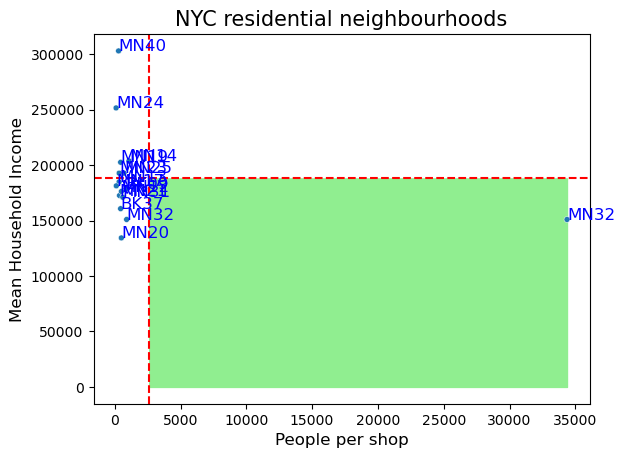

In [243]:
# visualisation
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    p1 = sns.scatterplot(x=x, y=y, data=data, size=8, legend=False)

    texts = [p1.text(data[x][line], data[y][line], 
             data[text_column][line], horizontalalignment='left', 
             size='large', color='blue') for line in range(0,data.shape[0])]

    plt.title(title, size=15)
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    
    return p1
    
# Using the average people per shop and average income as the threshold
avg_people_per_shop = nyc_cluster_result['People_Per_Shop'].mean()
max_people_per_shop = nyc_cluster_result['People_Per_Shop'].max()
avg_income = nyc_cluster_result['Median_Household_Income'].mean()

plt.axhline(y=avg_income, color='r', linestyle='--')
plt.axvline(x=avg_people_per_shop, color='r', linestyle='--')

# Highlight the optimal quadrant
plt.fill_between(x=np.arange(avg_people_per_shop, max_people_per_shop), y1=0, y2=avg_income, color='lightgreen')

# Draw and label the neighbourhood points
scatter_text('People_Per_Shop', 'Median_Household_Income', 'GeoID',
             data = nyc_cluster_result, 
             title = 'NYC residential neighbourhoods', 
             xlabel = 'People per shop',
             ylabel = 'Mean Household Income')

In [239]:
nyc_cluster_result.loc[nyc_cluster_result.People_Per_Shop.idxmax()]

index                                  77
Pop_Total_25_44                     34367
Pop_Pct_25_44                    0.422833
Pop_Male                         0.430227
Pop_Female                       0.569773
Median_Age                           38.1
Pop_Pct_Hisp_Latin               0.103386
Pop_Pct_Non_Hisp_Latin           0.896614
Pop_Pct_White                    0.745934
Pop_Pct_Black                    0.030685
Pop_Pct_American                 0.000431
Pop_Pct_Asia                     0.089237
Pop_Pct_Native                   0.001649
Pop_Pct_Employ                   0.718739
Pop_Pct_Employ_Salary            0.858965
Pop_Pct_Household_Earn_75_99     0.117675
Pop_Pct_Family_Earn_75_99        0.083422
Median_Household_Income          150969.0
Median_Family_Income             165223.0
Median_Earning                    72077.0
Pop_Pct_Healthy                  0.949504
Pct_Occupied_House               0.913228
Median_Room                           3.1
Median_House                     7

In [241]:
nyc_cluster_result.sort_values('People_Per_Shop')[['GeogName', 'Borough', 'People_Per_Shop']].head(10)

,GeogName,Borough,People_Per_Shop
9,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan,102.610465
7,Midtown-Midtown South,Manhattan,121.595960
11,Upper East Side-Carnegie Hill,Manhattan,291.588235
4,Hudson Yards-Chelsea-Flat Iron-Union Square,Manhattan,328.915888
13,West Village,Manhattan,338.505747
3,Gramercy,Manhattan,363.121212
1,Park Slope-Gowanus,Brooklyn,446.643836
10,Turtle Bay-East Midtown,Manhattan,449.181818
8,Murray Hill-Kips Bay,Manhattan,504.243902
12,Upper West Side,Manhattan,506.941860
